## Risk Score

The objective of this jupyter notebook file is to calculate and predict a risk score for football players in a fantasy football league. Especially when drafting players in 12 team PPR league, it is necessary to understand how consistent a player is. Specifically for starters, each player must be consistent and performing to they're expected output (or even better). However, as the draft continues on and bench players begin to be drafted, it is important for these players to have a higher risk score. Although such players are not as reliable as starter, they have high ceilings for points and even the potential to outperform some of the starters. Thus, being able to predict a player's risk from available will be central to drafting an effective fantasy football team able to autodrafted teams.

In [91]:
# Imports
%pip install nfl_data_py
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

Note: you may need to restart the kernel to use updated packages.


## Data Pre-Processing

In [92]:
data_2013 = nfl.import_seasonal_data([2013], 'REG')
data_2013.head()

,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,...,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
0,00-0006101,2013,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.105066,0.447902,0.188833,0.307692,0.246696,0.252964,0.248263,0.212605,1.305471,0.147550
1,00-0007091,2013,REG,7,12,130.0,0,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009948
2,00-0010346,2013,REG,450,659,5477.0,55,10.0,18.0,120.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199953
3,00-0015754,2013,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.083218,0.204834,0.076008,0.000000,0.106667,0.096386,0.038004,0.060806,0.497835,0.049018
4,00-0018956,2013,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.072464,0.040609,0.037975,0.000000,0.090909,0.076923,0.018987,0.030380,0.264706,0.023319


## Calculating Risk

When it comes to calculating the risk of a football player, we are going to be primarily considered with the their variation. For this project, we will calculate the coefficient of variation and use that to determine the risk of a player. In order to do so, we need to compute the total amount of points per game and the standard deviation for each player.

In [113]:
def calculate_risk(season_df, weekly_df):
    season_df = pd.merge(season_df.loc[season_df["games"] > 3], weekly_df[["player_id", "player_name", "position_group"]], 
                         how="left", on="player_id").drop_duplicates()
    season_df["FPG"] = season_df["fantasy_points_ppr"] / season_df["games"]
    grouped_df = weekly_df.groupby(["player_id"])["fantasy_points_ppr"].std().rename("SD_PTS")
    updated = pd.merge(season_df, grouped_df, on="player_id", how="left")
    updated["CV"] = (updated["FPG"] / updated["SD_PTS"]) * 10
    return updated


## Predict Risk

Now, we will predict the risk (CV) of fantasy football players in 2022 and assess the accuracy of the model from there.

In [116]:
def preprocess(years):
    season_df = nfl.import_seasonal_data(years=years, s_type='REG')
    weekly_df = nfl.import_weekly_data(years=years)
    season_df = nfl.clean_nfl_data(season_df)
    weekly_df = nfl.clean_nfl_data(weekly_df)
    print(weekly_df['fantasy_points_ppr'])
    season_df = calculate_risk(season_df, weekly_df.loc[weekly_df["season_type"] == "REG"])
    return season_df

data_2021 = preprocess([2021])
data_2022 = preprocess([2022])

data_2022 = data_2022[["player_id", "CV"]]
merged = pd.merge(data_2021, data_2022, how="inner", on="player_id", suffixes=('_2021', '_2022'))
merged

Downcasting floats.
0       27.160000
1       29.639999
2       28.680000
3       11.060000
4       37.740002
          ...    
5693    11.380000
5694    12.000000
5695    23.180000
5696    13.360000
5697     9.880000
Name: fantasy_points_ppr, Length: 5698, dtype: float32
       player_id  season season_type  completions  attempts  passing_yards  \
0     00-0019596    2021         REG          485       719         5316.0   
17    00-0022924    2021         REG          390       605         3740.0   
33    00-0023459    2021         REG          366       531         4115.0   
49    00-0024243    2021         REG            0         0            0.0   
62    00-0025394    2021         REG            0         0            0.0   
...          ...     ...         ...          ...       ...            ...   
5092  00-0036999    2021         REG            0         0            0.0   
5104  00-0037005    2021         REG            0         0            0.0   
5118  00-0037011    2021 

,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,...,dom,w8dom,yptmpa,ppr_sh,player_name,position_group,FPG,SD_PTS,CV_2021,CV_2022
0,00-0019596,2021,REG,485,719,5316.0,43,12.0,22.0,144.0,...,0.000000,0.000000,0.000000,0.195705,T.Brady,QB,22.043529,8.757814,25.170126,22.440212
1,00-0023459,2021,REG,366,531,4115.0,37,4.0,30.0,188.0,...,-0.000461,-0.000738,-0.007156,0.207297,A.Rodgers,QB,20.831250,7.787484,26.749655,36.494387
2,00-0024243,2021,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.032248,0.051597,0.467249,0.036543,M.Lewis,TE,3.415385,2.767925,12.339150,11.200621
3,00-0026143,2021,REG,375,560,3968.0,20,12.0,40.0,274.0,...,0.000000,0.000000,0.000000,0.171969,M.Ryan,QB,13.112941,7.958433,16.476788,18.213433
4,00-0026189,2021,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.097512,0.108019,0.922764,0.058574,D.Jackson,WR,5.414286,6.687515,8.096110,11.309097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,00-0036997,2021,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.115975,0.095560,0.584104,0.150183,J.Williams,RB,12.052941,6.634297,18.167624,15.595972
327,00-0036999,2021,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.056876,0.053502,0.373961,0.032463,A.Schwartz,WR,2.783333,4.005186,6.949323,6.783654
328,00-0037005,2021,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.076956,0.068584,0.360000,0.053186,T.Tremble,TE,3.792857,3.043900,12.460517,9.604165
329,00-0037011,2021,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.011987,0.019180,0.177165,0.015674,T.McKitty,TE,1.750000,1.915985,9.133682,10.448366


In [95]:
def train(x, y, pos):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

    lin_reg = LinearRegression()
    lin_reg.fit(x_train, y_train)
    preds = lin_reg.predict(x_test)

    plot(y_test, preds, pos)

def plot(actual, predicted, pos):
    fig, ax = plt.subplots()
    ax.scatter(actual, predicted)

    ax.set_xlabel('Actual CV')
    ax.set_ylabel('Predicted CV')

    ax.set_title('Actual vs Predicted')

    plt.show()

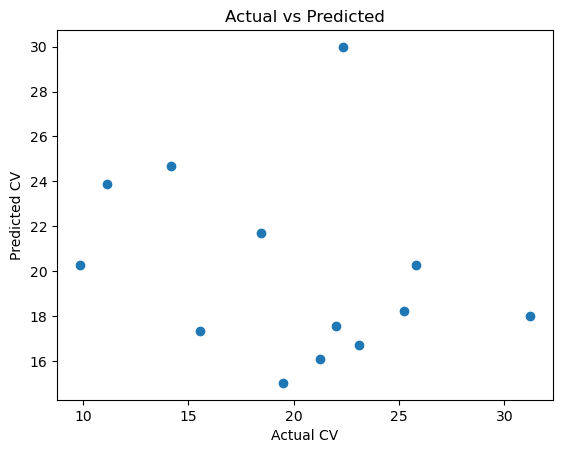

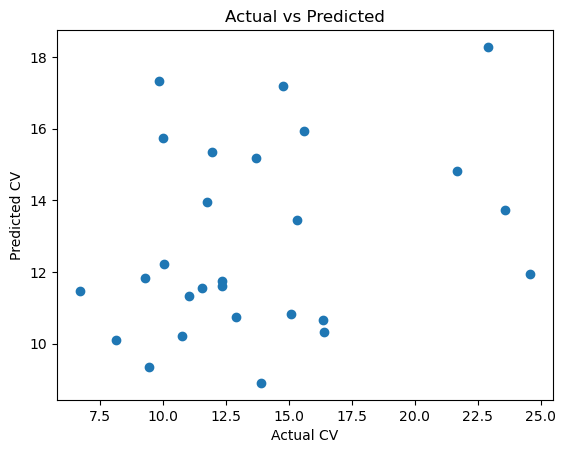

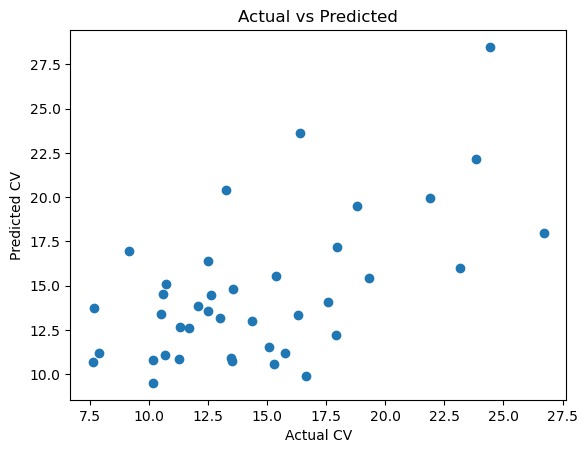

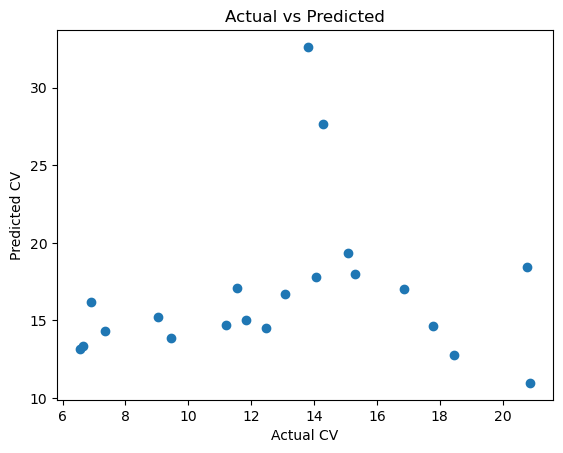

In [96]:
qb_data = merged.loc[merged["position_group"] == "QB"]
rb_data = merged.loc[merged["position_group"] == "RB"]
wr_data = merged.loc[merged["position_group"] == "WR"]
te_data = merged.loc[merged["position_group"] == "TE"]


qb_features = ['passing_tds', 'passing_yards', 'interceptions', 'sacks',
               'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards',
               'rushing_tds', 'rushing_fumbles_lost', 'CV_2021']

rb_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
               'rushing_2pt_conversions', 'receptions', 'receiving_yards',
               'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions',
               'CV_2021']

wr_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
               'rushing_2pt_conversions', 'receptions', 'receiving_yards',
               'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions',
               'CV_2021']

te_features = ['receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 
               'receiving_2pt_conversions', 'CV_2021']

train(qb_data[qb_features], qb_data["CV_2022"], "qb")
train(rb_data[rb_features], rb_data["CV_2022"], "rb")
train(wr_data[wr_features], wr_data["CV_2022"], "wr")
train(te_data[te_features], te_data["CV_2022"], "te")


In [97]:
# Groups the players by player data
def group_data_by_player(curr_player_records, player_data):

  # Stores all player records
  player_records = curr_player_records

  # Goes through the values in the player data
  for index, curr_entry in player_data.iterrows():

    # Adds the values in the player data to the player records
    curr_player = curr_entry['player_id']

    # Adds the current player's entry to the player records if lookup is found
    if (curr_player in player_records):
      player_records[curr_player].append(curr_entry)

    # Otherwise, we create a new entry
    else:
      player_records[curr_player] = [curr_entry]

  # Returns the player_records
  return player_records

In [98]:
# Gets the player statistics by input years
def get_player_vals_by_years(training_years, is_test):

  # Creates a dictionary to store the original values for the player data
  curr_players = dict()

  # Adds the players for each years into the curr_players dictionary
  for curr_year in training_years:

    # Gets the data for the year
    curr_data = preprocess([curr_year])

    # Adds the current year's information to the curr_players dictionary
    curr_players = group_data_by_player(curr_players, curr_data)

  # Cuts all players who haven't played for years
  player_data = dict()

  # Adds all players with multiyear data to our final player_data
  for player in curr_players:
    if (is_test or len(curr_players[player]) > 1):
      player_data[player] = curr_players[player]

  # Returns the player data by the desired years
  return player_data

In [99]:
# Get the player positions from the yearly rosters
def get_player_positions(curr_roster, off_pos_set):

  # Stores a dictionary for the player positions
  player_positions = dict()

  # Goes through the values in the player data
  for index, curr_entry in curr_roster.iterrows():

    # Gets the current position for each player
    curr_id = curr_entry['player_id']
    curr_pos = curr_entry['position']

    # If the player is in one of the positions we track, we add them
    if (curr_pos in off_pos_set):
      player_positions[curr_id] = curr_pos

  # Returns the player positions for each player
  return player_positions


# Sorts the players by position
def sort_players_by_position(player_positions, player_data, off_pos_set):

  # Stores the ultimate player by position directory
  players_by_position = dict()

  # Creates the starting dictionary for players within each position set
  for pos in off_pos_set:
    players_by_position[pos] = []

  # Goes through the values in the player data
  for curr_id in player_data:

    # If the player is in player_positions
    if (curr_id in player_positions):

      # Gets the position for the player
      curr_pos = player_positions[curr_id]

      # Sorts the player data into the position grouping
      #for curr_entry in player_data[curr_id]:
      players_by_position[curr_pos].append(player_data[curr_id])

  # Returns the player data by position
  return players_by_position

In [100]:
# Creates the x-y pairs for prediction based on our feature variables
# X-Value -- Desired features in the current player
# Y-Value -- The Fantasy PPR Score for the Following Year divided by the number of games
#            NOTE: We make the prediction Points Per Game to limit the prediction
#            in this part of the analysis to just production. Injury status
#            and riskiness will come in at a later point in the process.
def create_x_y_pairs(curr_players, regularization_args):

  # Creates an array to store the x y pairs of the players
  x_values = []
  y_values = []

  # Loops through the players to determine the x-y pairs
  for player in curr_players:

    # Begins the year pairing
    x_year = player[0]

    # Loops through the years for the players
    for next_year in range (1, len(player), 1):

      # Adds the next year to the function
      y_year = player[next_year]

      # Adds the year score pair to the x_y_pairs for the player
      x_games = x_year['games']
      regularized_x = x_year[regularization_args] / x_games
      x_year[regularization_args] = regularized_x

      x_values.append(x_year)
      y_values.append(y_year['CV'])

      # Resets the x_year to be the preceding year
      x_year = y_year

  # Returns the train and test sets
  return (x_values, y_values)

In [112]:
# Stores all features that could be useful for a QB
full_qb_features = ['completions', 'attempts', 'passing_yards', 'passing_tds',
                    'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
                    'sack_fumbles_lost', 'passing_air_yards',
                    'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
                    'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
                    'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
                    'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions']

# Stores all features that could be useful for a RB
full_rb_features = ['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
                    'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
                    'rushing_2pt_conversions', 'receptions', 'targets',
                    'receiving_yards', 'receiving_tds', 'receiving_fumbles',
                    'receiving_fumbles_lost', 'receiving_air_yards',
                    'receiving_yards_after_catch', 'receiving_first_downs',
                    'receiving_epa', 'receiving_2pt_conversions', 'racr',
                    'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh',
                    'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh',
                    'rtdfd_sh', 'yptmpa']

# Stores all features that could be useful for a WR
full_wr_features = ['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
                    'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
                    'rushing_2pt_conversions', 'receptions', 'targets',
                    'receiving_yards', 'receiving_tds', 'receiving_fumbles',
                    'receiving_fumbles_lost', 'receiving_air_yards',
                    'receiving_yards_after_catch', 'receiving_first_downs',
                    'receiving_epa', 'receiving_2pt_conversions', 'racr',
                    'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh',
                    'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh',
                    'rtdfd_sh', 'yptmpa']

# Stores the years which we're training on
training_years = range(2010, 2022, 1)

# Stores the offensive positions that we track for fantasy input
off_pos_set = ['QB', 'RB', 'WR', 'TE']

# Gets the player data for the selected years
initial_player_data = get_player_vals_by_years(training_years, False)

# Gets the player rosters for each id
player_rosters = nfl.import_seasonal_rosters(training_years, ['player_id', 'position'])

# Gets the player positions for each id
player_positions = get_player_positions(player_rosters, off_pos_set)

# Sorts the player data by position
player_data_by_position = sort_players_by_position(player_positions, initial_player_data, off_pos_set)

Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
player_id         00-0004541
season                  2011
season_type              REG
completions                0
attempts                   0
                     ...    
player_name             None
position_group            WR
FPG                  7.34375
SD_PTS               5.39765
CV                 13.605459
Name: 0, Length: 63, dtype: object


In [102]:
# Creates the initial cleaned data set
# TODO: Make these different features for non qb, rb, wr, te
qb_x, qb_y = create_x_y_pairs(player_data_by_position['QB'], full_qb_features)
rb_x, rb_y = create_x_y_pairs(player_data_by_position['RB'], full_rb_features)
wr_x, wr_y = create_x_y_pairs(player_data_by_position['WR'], full_qb_features)
te_x, te_y = create_x_y_pairs(player_data_by_position['TE'], full_qb_features)

In [103]:
# Splits all the data into train and test sets for the data
qb_x_train, qb_x_test, qb_y_train, qb_y_test = train_test_split(qb_x, qb_y, test_size=0.2)
rb_x_train, rb_x_test, rb_y_train, rb_y_test = train_test_split(rb_x, rb_y, test_size=0.2)
wr_x_train, wr_x_test, wr_y_train, wr_y_test = train_test_split(wr_x, wr_y, test_size=0.2)
te_x_train, te_x_test, te_y_train, te_y_test = train_test_split(te_x, te_y, test_size=0.2)

Correlation is: 0.4296958442784293


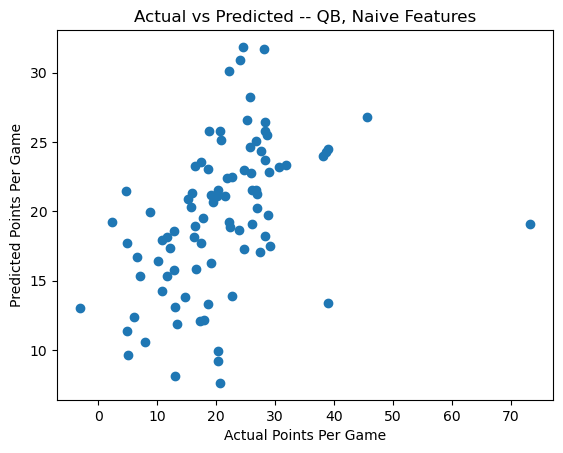

In [104]:
qb_baseline_features = ['passing_tds', 'passing_yards', 'interceptions', 'sacks',
                        'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards',
                        'rushing_tds', 'rushing_fumbles_lost', 'FPG']


# Selects the baselines features for the model
baseline_x_train = pd.DataFrame(qb_x_train)[qb_baseline_features]
baseline_x_test = pd.DataFrame(qb_x_test)[qb_baseline_features]

# Creates and fits the model
linear_reg_model = LinearRegression()
linear_reg_model.fit(baseline_x_train, qb_y_train)
qb_y_pred = linear_reg_model.predict(baseline_x_test)

# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(qb_y_test, qb_y_pred)[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(qb_y_test, qb_y_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- QB, Naive Features')

plt.show()

Correlation is: 0.3282076572910455


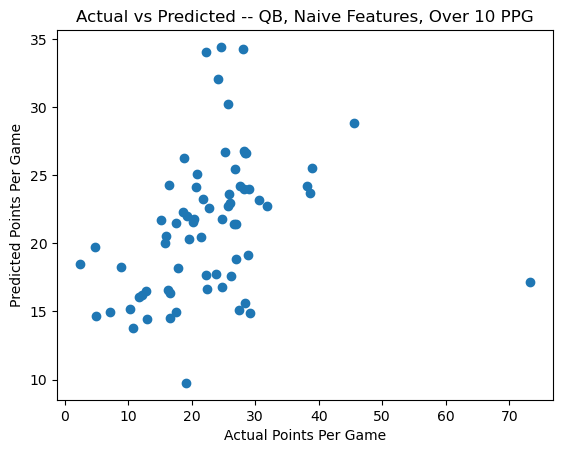

In [105]:
# Selects the baselines features for the model
qb_x_train = pd.DataFrame(qb_x_train)
qb_x_test = pd.DataFrame(qb_x_test)
baseline_x_train = qb_x_train[qb_baseline_features]
baseline_x_test = qb_x_test[qb_baseline_features]
baseline_y_train = pd.DataFrame(qb_y_train)
baseline_y_test = pd.DataFrame(qb_y_test)

# Takes the values over 10 ppg
train_mask = np.where(((qb_x_train['FPG']) > 10), 1, 0)
test_mask  = np.where(((qb_x_test['FPG']) > 10), 1, 0)

over_10_x_train = baseline_x_train.loc[train_mask == 1]
over_10_x_test = baseline_x_test.loc[test_mask == 1]
over_10_y_train = baseline_y_train.loc[train_mask == 1]
over_10_y_test = baseline_y_test.loc[test_mask == 1]

# Creates and fits the model
naive_model = LinearRegression()
naive_model.fit(over_10_x_train, over_10_y_train)
over_10_y_pred = naive_model.predict(over_10_x_test)
over_10_y_pred = over_10_y_pred.flatten()
over_10_y_test = (over_10_y_test.values).flatten()

# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(over_10_y_test, over_10_y_pred)[0, 1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(over_10_y_test, over_10_y_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- QB, Naive Features, Over 10 PPG')

plt.show()